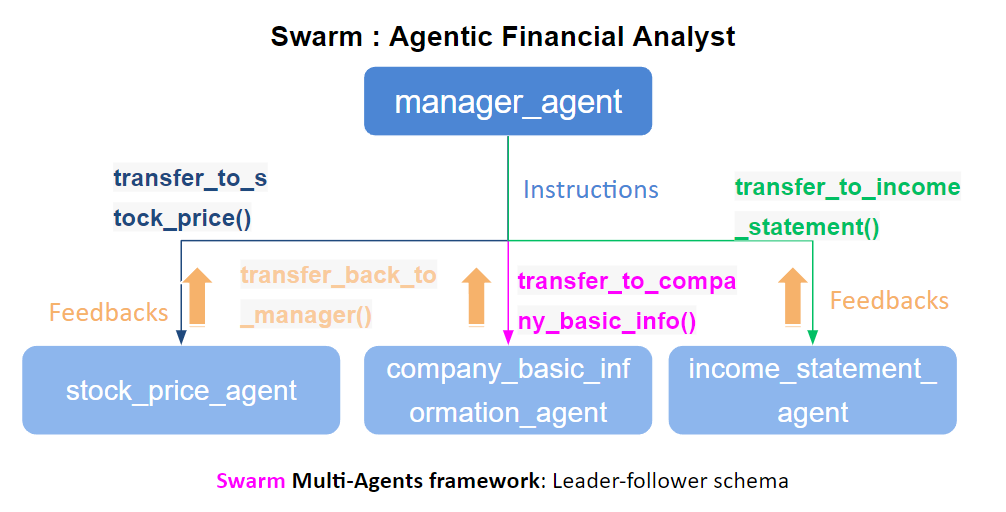

In [4]:
from IPython.display import Image, display
display(Image(filename=image_path)) #local path

# How to set up the Swarm (OpenAI) multi-agent framework for financial analysis?

Swarm is a multi-agent orchestration framework developed by OpenAI. Currently, it serves as an experimental framework designed to explore user-friendly interfaces for multi-agent systems. It's not intended for production use and lacks official support.


👉 Pros and Cons:

-  **Pros**: Swarm is designed to be lightweight, scalable, and easy to customize. You can add and manage many independent tasks and instructions that are hard to fit into a single prompt. Each agent can be assigned unique instructions and functions, allowing it to specialize in specific tasks.


-  **Cons**: Swarm requires manual memory management by the user, in contrast to the Assistant AI API, which provides fully hosted threads and integrated memory management.


👉 So, How to set up the Swarm multi-agent framework for financial analysis purpose?


I created 4 agents:

-  **manager_agent**: This agent will handle determning and switching between agents to transfer the user's request to the best suited agent.

-  **stock_price_agent**: This agent is responsible of fetching the last available price, volume, average price 50d, 200d, EPS, PE, and the next earnings annoucement.

-  **company_basic_information_agent**: This agent is responsible of collecting the company basic data like description market capitalization, sector, industry...

-  **income_statement_agent**: This agent is responsible of gathering the last income statement data such as revenue, gross profit, net income, EBITDA, EPS.

* For each sub-agent, I define a set of functions to handle collecting the appropriate data.
* The manager agent will manage functions that distribute the request to the various agents.
* Each sub-agent will have a function to transfer request back to the manager.


👉 Discover how this framework works in this notebook: 👇

[Hanane DUPOUY](https://www.linkedin.com/in/hanane-d-algo-trader)

# Install Swarm

In [ ]:
pip install git+https://github.com/openai/swarm.git -q

In [3]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

import requests

FINANCIAL_MODELING_PREP_API_KEY = userdata.get('FINANCIAL_MODELING_PREP_API_KEY')

# Define the functions:

By using **Financial Modeling PREP API**, I created these 3 functions to fetch different financial data for a given company symbol:

**get_stock_price**, **get_company_financials**, **get_income_statement**

In [7]:
def get_stock_price(symbol):
    """
    Fetch the current stock price for the given symbol, the current volume, the average price 50d and 200d, EPS, PE and the next earnings Announcement.
    """
    url = f"https://financialmodelingprep.com/api/v3/quote-order/{symbol}?apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    response = requests.get(url)
    data = response.json()
    try:
        price = data[0]['price']
        volume = data[0]['volume']
        priceAvg50 = data[0]['priceAvg50']
        priceAvg200 = data[0]['priceAvg200']
        eps = data[0]['eps']
        pe = data[0]['pe']
        earningsAnnouncement = data[0]['earningsAnnouncement']
        return {"symbol": symbol.upper(), "price": price, "volume":volume,"priceAvg50":priceAvg50, "priceAvg200":priceAvg200, "EPS":eps, "PE":pe, "earningsAnnouncement":earningsAnnouncement }
    except (IndexError, KeyError):
        return {"error": f"Could not fetch price for symbol: {symbol}"}

def get_company_financials(symbol):
    """
    Fetch basic financial information for the given company symbol such as the industry, the sector, the name of the company, and the market capitalization.
    """
    url = f"https://financialmodelingprep.com/api/v3/profile/{symbol}?apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    response = requests.get(url)
    data = response.json()
    try:
        results = data[0]
        financials = {
            "symbol": results["symbol"],
            "companyName": results["companyName"],
            "marketCap": results["mktCap"],
            "industry": results["industry"],
            "sector": results["sector"],
            "website": results["website"],
            "beta":results["beta"],
            "price":results["price"],
        }
        return financials
    except (IndexError, KeyError):
        return {"error": f"Could not fetch financials for symbol: {symbol}"}

def get_income_statement(symbol):
    """
    Fetch last income statement for the given company symbol such as revenue, gross profit, net income, EBITDA, EPS.
    """
    url = f"https://financialmodelingprep.com/api/v3/income-statement/{symbol}?period=annual&apikey={FINANCIAL_MODELING_PREP_API_KEY}"
    response = requests.get(url)
    data = response.json()
    try:
        results = data[0]
        financials = {
            "date": results["date"],
            "revenue": results["revenue"],
            "gross profit": results["grossProfit"],
            "net Income": results["netIncome"],
            "ebitda": results["ebitda"],
            "EPS": results["eps"],
            "EPS diluted":results["epsdiluted"]
        }
        return data, financials
    except (IndexError, KeyError):
        return {"error": f"Could not fetch financials for symbol: {symbol}"}

# Specify the Agents

-  **manager_agent**: This agent will handle determning and switching between agents to transfer the user's request to the best suited agent.

-  **stock_price_agent**: This agent is responsible of fetching the last available price, volume, average price 50d, 200d, EPS, PE, and the next earnings annoucement.

-  **company_basic_information_agent**: This agent is responsible of collecting the company basic data like description market capitalization, sector, industry...

-  **income_statement_agent**: This agent is responsible of gathering the last income statement data such as revenue, gross profit, net income, EBITDA, EPS.

* For each sub-agent, I define a set of function to handle collecting the adequate data.
* The manager agent will handle function that transfer the request to the different agents.
* Each sub-agent will have a function that the transfer back tho the manager.

In [8]:
from swarm import Agent

manager_agent = Agent(
    name="Manager Agent",
    instructions="Determine which agent is best suited to handle the user's request, and transfer the conversation to that agent.",
)
stock_price_agent = Agent(
    name="Stock Price Agent",
    instructions="Fetch Hsitorical prices for a given stock symbol, the current volume, the average price 50d and 200d, EPS, PE and the next earnings Announcement.",
    functions=[get_stock_price],
)

company_basic_information_agent = Agent(
    name="Company basic information Agent",
    instructions="Fetch basic financial information for the given company symbol such as the industry, the sector, the name of the company, and the market capitalization.",
    functions=[get_company_financials],
)

income_statement_agent = Agent(
    name="Income Statement Agent",
    instructions=" Fetch last income statement for the given company symbol such as revenue, gross profit, net income, EBITDA, EPS.",
    functions=[get_income_statement],
)


def transfer_back_to_manager():
    """Call this function if a user is asking about a topic that is not handled by the current agent."""
    return manager_agent


def transfer_to_stock_price():
    return stock_price_agent

def transfer_to_company_basic_info():
    return company_basic_information_agent

def transfer_to_income_statement():
    return income_statement_agent


manager_agent.functions = [transfer_to_stock_price, transfer_to_company_basic_info, transfer_to_income_statement]
stock_price_agent.functions.append(transfer_back_to_manager)
company_basic_information_agent.functions.append(transfer_back_to_manager)
income_statement_agent.functions.append(transfer_back_to_manager)

# Chating with the Agents:

I asked different questions:

 -  What is the current stock price of Amazon and Nvidia

 -  What is their market capitalization?

 -  What is the EPS of Apple?

 -  When will the next earnings announcement be?

 -  What is the revenue of Amazon?

 You can see the different calls and communications between the manager agent and the different sub-agents:

In [15]:
# You can get this code from "from swarm.repl import run_demo_loop"==>I've extracted here to add "exit" to break the loop.
import json

from swarm import Swarm

def process_and_print_streaming_response(response):
    content = ""
    last_sender = ""

    for chunk in response:
        if "sender" in chunk:
            last_sender = chunk["sender"]

        if "content" in chunk and chunk["content"] is not None:
            if not content and last_sender:
                print(f"\033[94m{last_sender}:\033[0m", end=" ", flush=True)
                last_sender = ""
            print(chunk["content"], end="", flush=True)
            content += chunk["content"]

        if "tool_calls" in chunk and chunk["tool_calls"] is not None:
            for tool_call in chunk["tool_calls"]:
                f = tool_call["function"]
                name = f["name"]
                if not name:
                    continue
                print(f"\033[94m{last_sender}: \033[95m{name}\033[0m()")

        if "delim" in chunk and chunk["delim"] == "end" and content:
            print()  # End of response message
            content = ""

        if "response" in chunk:
            return chunk["response"]


def pretty_print_messages(messages) -> None:
    for message in messages:
        if message["role"] != "assistant":
            continue

        # print agent name in blue
        print(f"\033[94m{message['sender']}\033[0m:", end=" ")

        # print response, if any
        if message["content"]:
            print(message["content"])

        # print tool calls in purple, if any
        tool_calls = message.get("tool_calls") or []
        if len(tool_calls) > 1:
            print()
        for tool_call in tool_calls:
            f = tool_call["function"]
            name, args = f["name"], f["arguments"]
            arg_str = json.dumps(json.loads(args)).replace(":", "=")
            print(f"\033[95m{name}\033[0m({arg_str[1:-1]})")


def run_demo_loop(
    starting_agent, context_variables=None, stream=False, debug=False
) -> None:
    client = Swarm()
    print("Starting Swarm CLI 🐝")

    messages = []
    agent = starting_agent

    while True:
        user_input = input("\033[90mUser\033[0m: ")
        if user_input.lower() == "exit":
            break
        messages.append({"role": "user", "content": user_input})

        response = client.run(
            agent=agent,
            messages=messages,
            context_variables=context_variables or {},
            stream=stream,
            debug=debug,
        )

        if stream:
            response = process_and_print_streaming_response(response)
        else:
            pretty_print_messages(response.messages)

        messages.extend(response.messages)
        agent = response.agent


In [18]:
# write "exit" to exit the loop
run_demo_loop(manager_agent, debug=False)

Starting Swarm CLI 🐝
User: What is the current stock price of Amazon and Nvidia?
Manager Agent: 
transfer_to_stock_price()
transfer_to_stock_price()
Stock Price Agent: 
get_stock_price("symbol"= "AMZN")
get_stock_price("symbol"= "NVDA")
Stock Price Agent: The current stock information is as follows:

**Amazon (AMZN)**:
- Current Price: $191.23
- Volume: 15,906,252
- Average Price (50 days): $182.20 
- Average Price (200 days): $178.90
- Earnings Per Share (EPS): $4.20
- Price to Earnings Ratio (PE): 45.53
- Next Earnings Announcement: October 31, 2024

**Nvidia (NVDA)**:
- Current Price: $143.91
- Volume: 166,377,366
- Average Price (50 days): $122.37
- Average Price (200 days): $100.89
- Earnings Per Share (EPS): $2.14
- Price to Earnings Ratio (PE): 67.25
- Next Earnings Announcement: November 21, 2024
User: What is their market capitalization?
Stock Price Agent: transfer_back_to_manager()
Manager Agent: 
transfer_to_company_basic_info()
transfer_to_company_basic_info()
Company basic

# Key Takeways:

-  A highly customizable framework: Each agent is equipped with specific instructions to ensure clarity and optimal outcomes.

-  The implementation is broken down to the most granular level, allowing you to build your agent exactly as you desire.

-  There is no built-in memory management like the Assistant AI API provides.